## Single Cell RNA seq on 3K PBMC

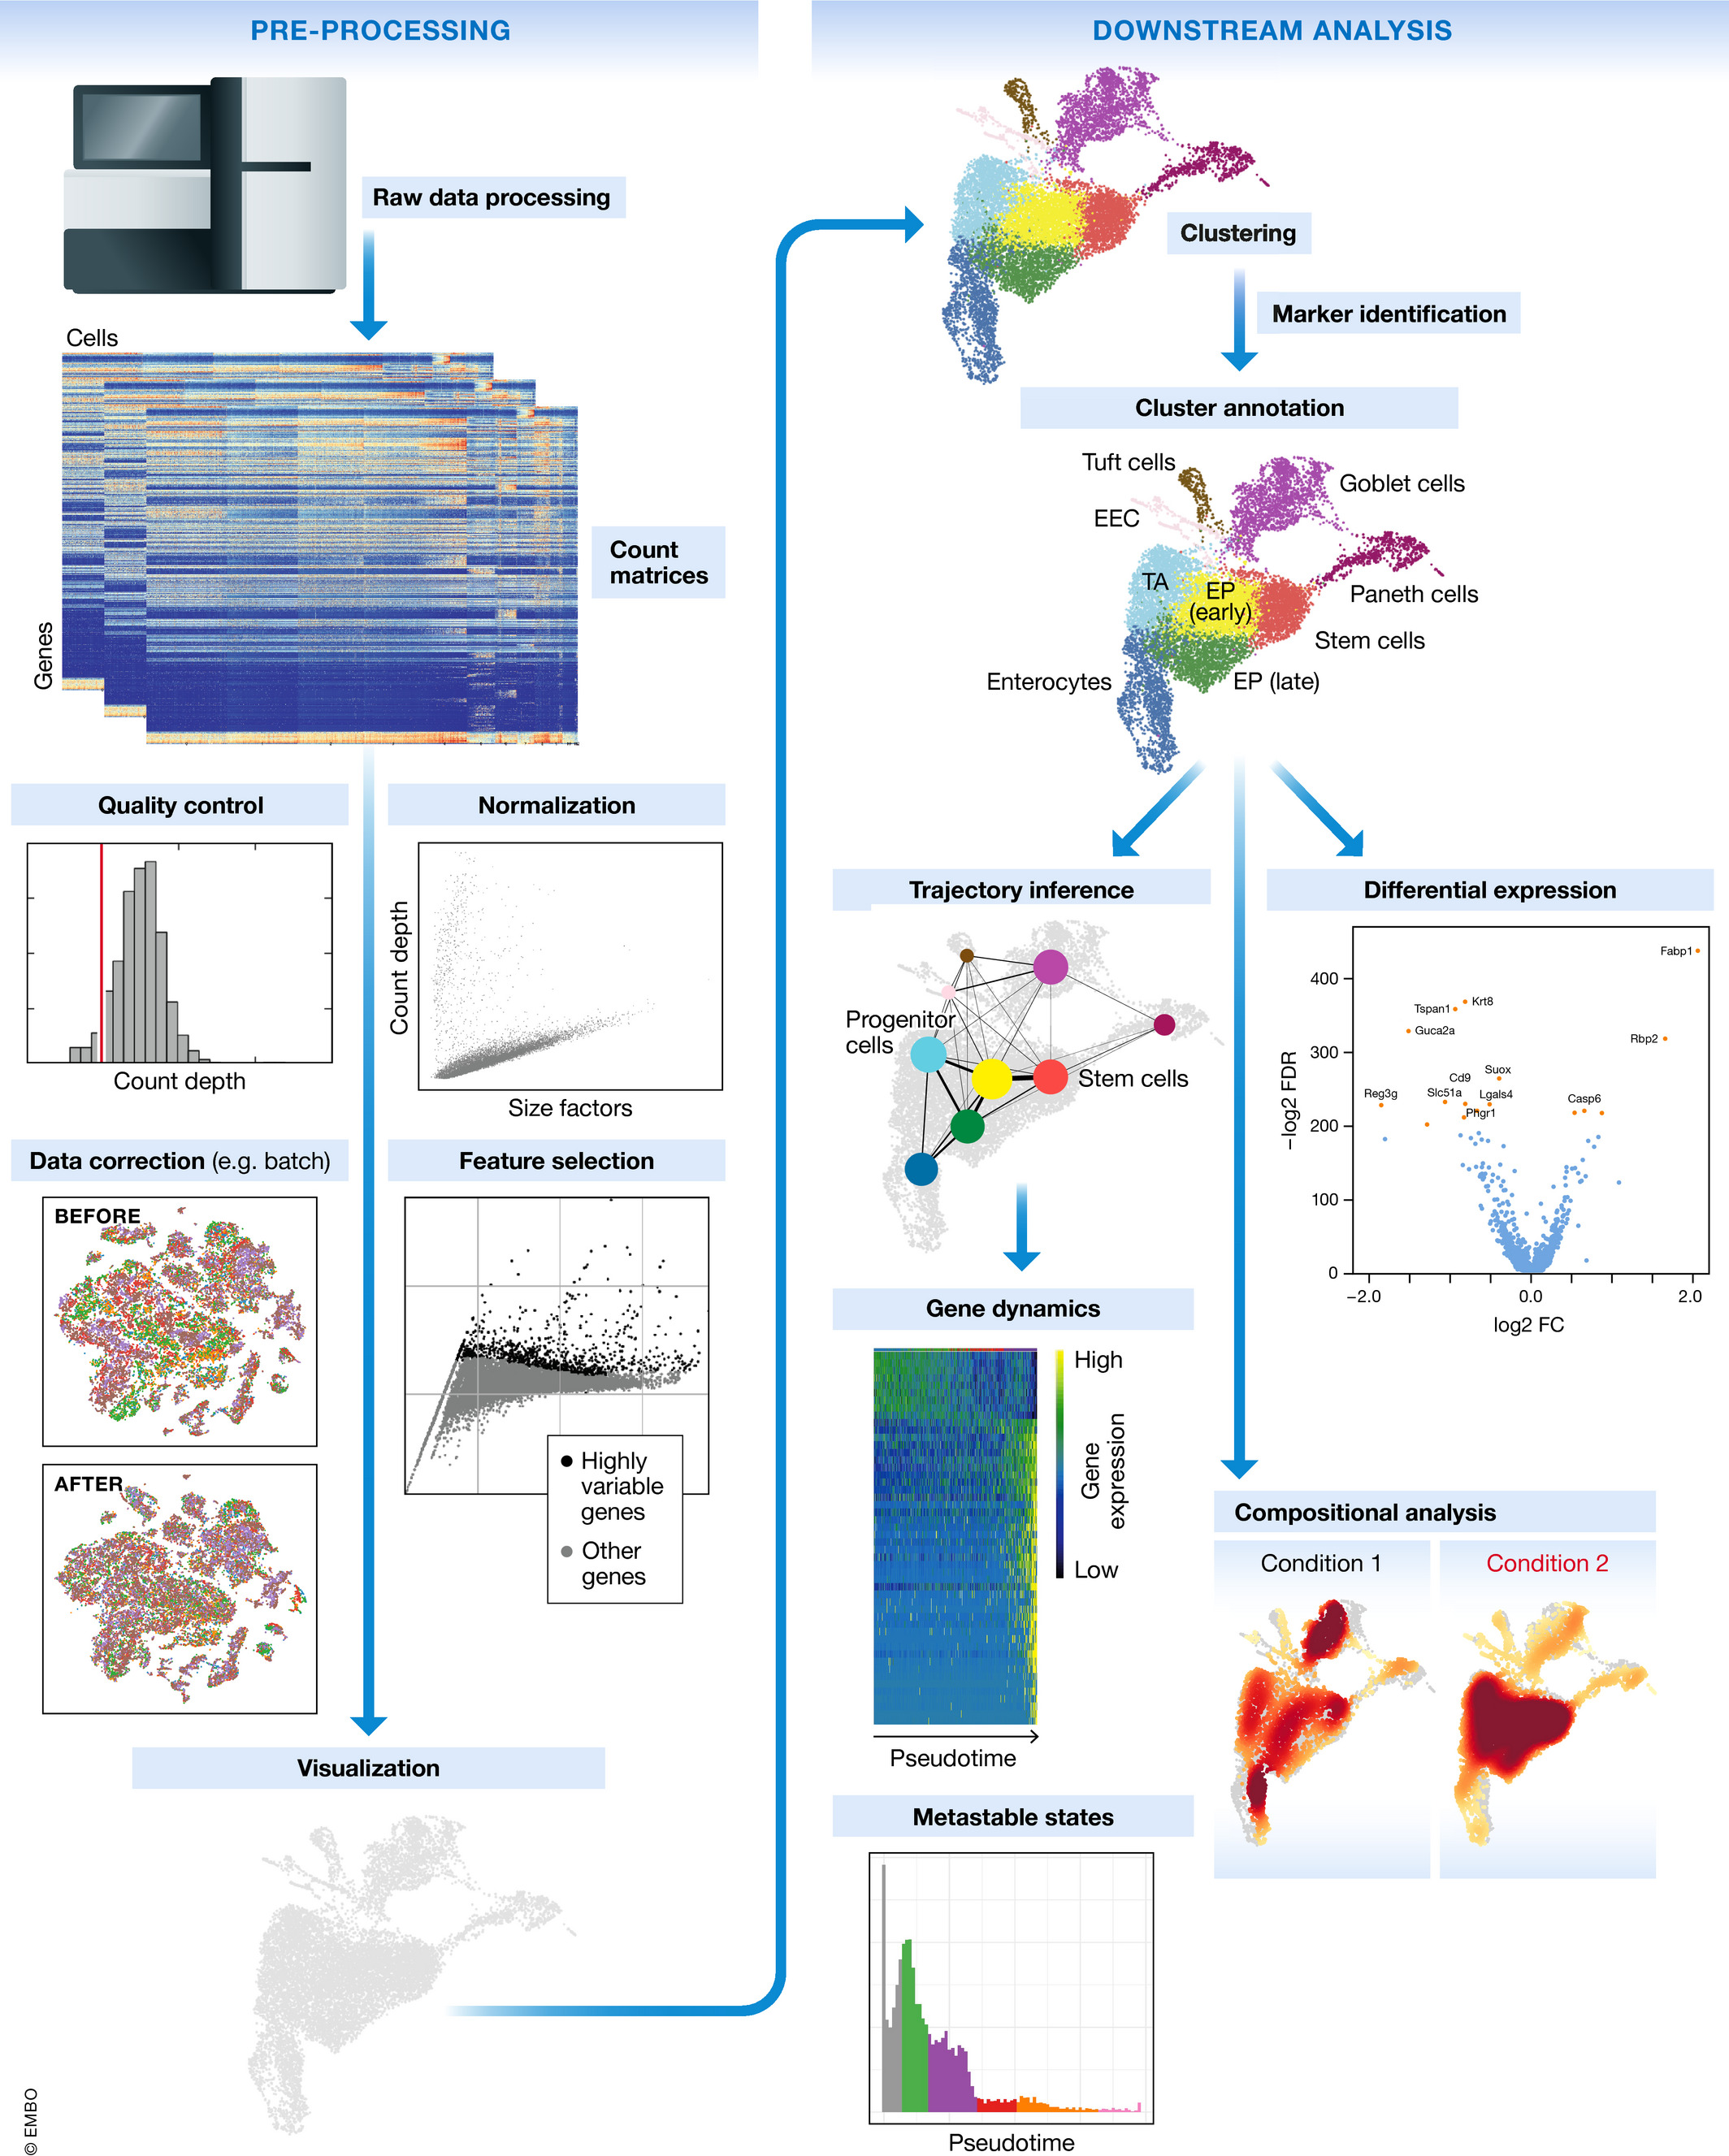

In [1]:
from IPython.display import Image
Image ('/Users/ChienTing/Downloads/msb188746-fig-0001-m.jpg',width=1000)

## Pre-processing

In [4]:
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import anndata as ad
import scvi

2023-10-11 20:57:06.509011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Global seed set to 0


In [7]:
data_path = '/Users/ChienTing/Desktop/Codeclass/Exercise/Single_cell_RNA_seq/hg19/'

In [8]:
sc.settings.verbosity = 3 
adata = sc.read_10x_mtx(data_path,var_names='gene_symbols', make_unique=True)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [9]:
# Filter out genes with low expression
sc.pp.filter_genes(adata, min_cells=10)

filtered out 21599 genes that are detected in less than 10 cells


In [10]:
adata

AnnData object with n_obs × n_vars = 2700 × 11139
    var: 'gene_ids', 'n_cells'

In [11]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [12]:
adata

AnnData object with n_obs × n_vars = 2700 × 2000
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [13]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|███████| 400/400 [05:01<00:00,  1.22it/s, loss=640, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████| 400/400 [05:01<00:00,  1.33it/s, loss=640, v_num=1]


In [14]:
# scvi package was developed by Adam Gayoso (Nature Biotechnology 2022)
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/ChienTing/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/ChienTing/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 380/400:  95%|████▊| 380/400 [01:00<00:03,  6.33it/s, loss=0.202, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.192. Signaling Trainer to stop.


In [15]:
df=solo.predict()
df['prediction']=solo.predict(soft=False)
df.index=df.index.map(lambda X:X[:-2])

In [16]:
df

,doublet,singlet,prediction
AAACATACAACCAC-1,-2.326702,1.920726,singlet
AAACATTGAGCTAC-1,0.805525,-1.033267,doublet
AAACATTGATCAGC-1,1.316929,-0.881703,doublet
AAACCGTGCTTCCG-1,-0.742162,0.366376,singlet
AAACCGTGTATGCG-1,-3.809975,4.340193,singlet
...,...,...,...
TTTCGAACTCTCAT-1,0.110464,-0.328500,doublet
TTTCTACTGAGGCA-1,-0.026726,0.159200,singlet
TTTCTACTTCCTCG-1,-0.133735,1.048051,singlet
TTTGCATGAGAGGC-1,-0.677655,1.963231,singlet


In [17]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,413,413
singlet,2287,2287


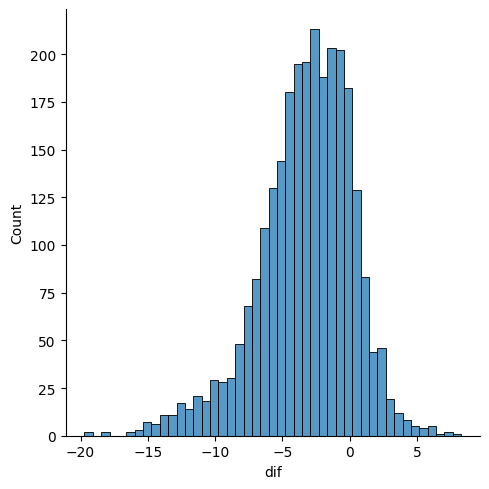

In [18]:
df['dif'] = df.doublet - df.singlet
sns.displot(data=df[df.prediction=='doublet'],x=df['dif'])

In [19]:
df[df.prediction=='doublet']

,doublet,singlet,prediction,dif
AAACATTGAGCTAC-1,0.805525,-1.033267,doublet,1.838792
AAACATTGATCAGC-1,1.316929,-0.881703,doublet,2.198632
AAACGCACTGGTAC-1,0.234818,-0.330331,doublet,0.565149
AAACTTGAAAAACG-1,1.658428,-1.051069,doublet,2.709497
AAAGAGACGCGAGA-1,-0.076039,-0.169414,doublet,0.093375
...,...,...,...,...
TTGCATTGCTAAGC-1,1.267568,-1.080197,doublet,2.347765
TTGGAGACCAATCG-1,1.247103,-2.286343,doublet,3.533446
TTTAGCTGGATACC-1,0.076315,-0.258726,doublet,0.335041
TTTAGCTGTACTCT-1,0.677234,-1.053524,doublet,1.730758


In [20]:
adata = sc.read_10x_mtx(data_path,var_names='gene_symbols', make_unique=True)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [21]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [22]:
doublets = df[(df.prediction == 'doublet')]
adata.obs['doublet']=adata.obs.index.isin(doublets.index)
adata.obs

,doublet
AAACATACAACCAC-1,False
AAACATTGAGCTAC-1,True
AAACATTGATCAGC-1,True
AAACCGTGCTTCCG-1,False
AAACCGTGTATGCG-1,False
...,...
TTTCGAACTCTCAT-1,True
TTTCTACTGAGGCA-1,False
TTTCTACTTCCTCG-1,False
TTTGCATGAGAGGC-1,False


In [23]:
adata=adata[~adata.obs.doublet]

In [24]:
adata.var

,gene_ids
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945
...,...
AC145205.1,ENSG00000215635
BAGE5,ENSG00000268590
CU459201.1,ENSG00000251180
AC002321.2,ENSG00000215616


In [25]:
adata.var['mt']=adata.var.index.str.startswith('MT-')

/var/folders/17/_8p2blxn6sx5s_0v13jyvtgw0000gn/T/ipykernel_22229/1380960737.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt']=adata.var.index.str.startswith('MT-')


In [26]:
adata.var[adata.var.index.str.startswith('MT-')]

,gene_ids,mt
MT-ND1,ENSG00000198888,True
MT-ND2,ENSG00000198763,True
MT-CO1,ENSG00000198804,True
MT-CO2,ENSG00000198712,True
MT-ATP8,ENSG00000228253,True
MT-ATP6,ENSG00000198899,True
MT-CO3,ENSG00000198938,True
MT-ND3,ENSG00000198840,True
MT-ND4L,ENSG00000212907,True
MT-ND4,ENSG00000198886,True


In [27]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [28]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [29]:
adata.var['rib']=adata.var.index.isin(ribo_genes[0].values)

In [30]:
adata.var

,gene_ids,mt,rib
MIR1302-10,ENSG00000243485,False,False
FAM138A,ENSG00000237613,False,False
OR4F5,ENSG00000186092,False,False
RP11-34P13.7,ENSG00000238009,False,False
RP11-34P13.8,ENSG00000239945,False,False
...,...,...,...
AC145205.1,ENSG00000215635,False,False
BAGE5,ENSG00000268590,False,False
CU459201.1,ENSG00000251180,False,False
AC002321.2,ENSG00000215616,False,False


In [31]:
sc.pp.calculate_qc_metrics(adata,qc_vars=['mt', 'rib'], percent_top=None, log1p=False, inplace=True)

In [32]:
adata.var.sort_values('n_cells_by_counts')

,gene_ids,mt,rib,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-10,ENSG00000243485,False,False,0,0.000000,100.000000,0.0
EDRF1-AS1,ENSG00000236991,False,False,0,0.000000,100.000000,0.0
TEX36,ENSG00000175018,False,False,0,0.000000,100.000000,0.0
TEX36-AS1,ENSG00000237675,False,False,0,0.000000,100.000000,0.0
FAM53B-AS1,ENSG00000233334,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...
RPL10,ENSG00000147403,False,True,2282,30.367731,0.218627,69451.0
RPL13A,ENSG00000142541,False,True,2285,26.881941,0.087451,61479.0
B2M,ENSG00000166710,False,False,2286,41.128990,0.043725,94062.0
MALAT1,ENSG00000251562,False,False,2286,58.586357,0.043725,133987.0


In [33]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_rib,pct_counts_rib
AAACATACAACCAC-1,False,781,2421.0,73.0,3.015283,1046.0,43.205288
AAACCGTGCTTCCG-1,False,960,2639.0,46.0,1.743085,644.0,24.403183
AAACCGTGTATGCG-1,False,522,981.0,12.0,1.223242,147.0,14.984709
AAACGCTGACCAGT-1,False,783,2176.0,83.0,3.814338,896.0,41.176472
AAACGCTGGTTCTT-1,False,790,2260.0,70.0,3.097345,866.0,38.318584
...,...,...,...,...,...,...,...
TTTCGAACACCTGA-1,False,1544,4460.0,58.0,1.300448,1223.0,27.421526
TTTCTACTGAGGCA-1,False,1227,3447.0,32.0,0.928343,1143.0,33.159267
TTTCTACTTCCTCG-1,False,622,1684.0,37.0,2.197150,670.0,39.786224
TTTGCATGAGAGGC-1,False,454,1024.0,21.0,2.050781,284.0,27.734375


In [34]:
sc.pp.filter_genes(data=adata,min_cells=3)

filtered out 19638 genes that are detected in less than 3 cells


In [35]:
adata.var

,gene_ids,mt,rib,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AL627309.1,ENSG00000237683,False,False,6,0.002624,99.737648,6.0,6
RP11-206L10.2,ENSG00000228327,False,False,3,0.001312,99.868824,3.0,3
LINC00115,ENSG00000225880,False,False,15,0.006559,99.344119,15.0,15
NOC2L,ENSG00000188976,False,False,190,0.094884,91.692173,217.0,190
KLHL17,ENSG00000187961,False,False,7,0.003061,99.693922,7.0,7
...,...,...,...,...,...,...,...,...
AC145212.1,ENSG00000215750,False,False,12,0.005684,99.475295,13.0,12
AL592183.1,ENSG00000220023,False,False,259,0.128553,88.675120,294.0,259
AL354822.1,ENSG00000215615,False,False,4,0.001749,99.825098,4.0,4
PNRC2-1,ENSG00000215700,False,False,84,0.038478,96.327066,88.0,84


In [36]:
adata.obs.sort_values('total_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_rib,pct_counts_rib
CAGTGTGAACACGT-1,False,307,548.0,36.0,6.569343,136.0,24.817518
ACACAGACACCTGA-1,False,299,551.0,34.0,6.170599,81.0,14.700544
GTCAACGATCAGGT-1,False,324,555.0,37.0,6.666667,119.0,21.441442
GAAATACTACCAAC-1,False,283,561.0,9.0,1.604278,136.0,24.242424
CACCCATGTTCTGT-1,False,333,561.0,25.0,4.456328,160.0,28.520498
...,...,...,...,...,...,...,...
CTAGGATGAGCCTA-1,False,1749,5878.0,92.0,1.565158,1965.0,33.429737
GCGTAAACACGGTT-1,False,1629,5928.0,127.0,2.142375,1738.0,29.318487
GCCTCAACTCTTTG-1,False,1963,5990.0,67.0,1.118531,1487.0,24.824707
AAGCACTGGTTCTT-1,False,1717,6157.0,145.0,2.355043,2674.0,43.430241


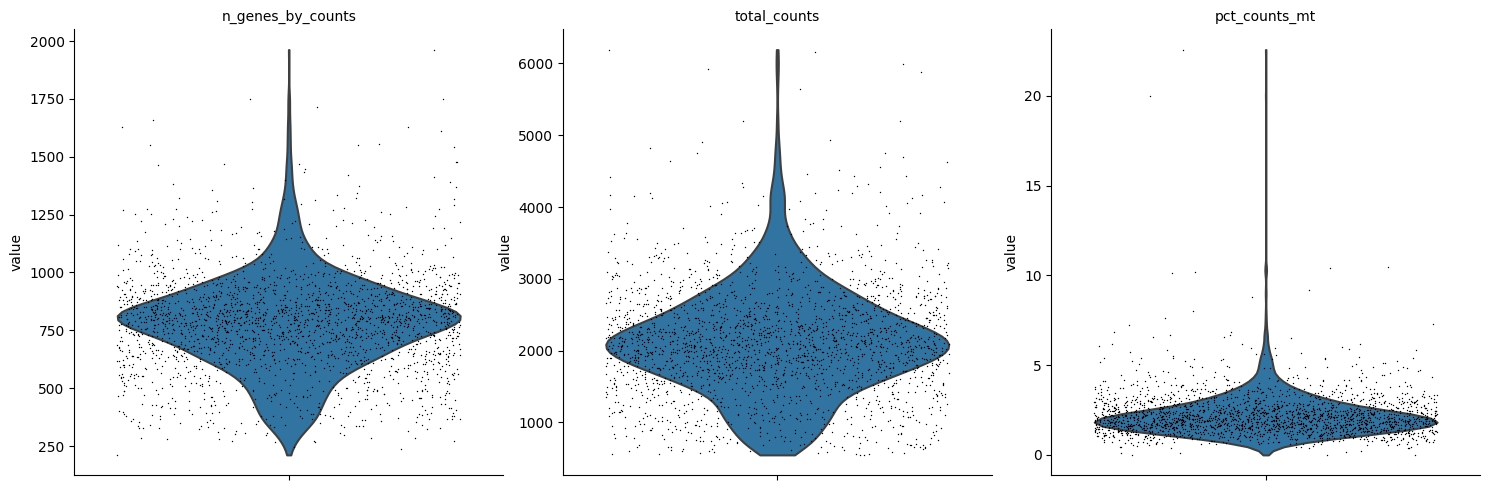

In [37]:
sc.pl.violin(adata,keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],multi_panel=True,jitter=0.4)

In [38]:
adata = adata[adata.obs.pct_counts_mt<5,:]

In [39]:
adata.obs.sort_values('n_genes_by_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_rib,pct_counts_rib
GGCATATGGGGAGT-1,False,212,575.0,7.0,1.217391,13.0,2.260870
CTAATAGAGCTATG-1,False,239,600.0,1.0,0.166667,330.0,55.000000
ATCTCAACCTCGAA-1,False,246,609.0,0.0,0.000000,329.0,54.022987
GACGCTCTCTCTCG-1,False,267,683.0,22.0,3.221083,15.0,2.196193
TAGTCTTGGCTGTA-1,False,270,652.0,0.0,0.000000,363.0,55.674847
...,...,...,...,...,...,...,...
TACTGTTGCTGAAC-1,False,1657,5201.0,166.0,3.191694,1753.0,33.705055
AAGCACTGGTTCTT-1,False,1717,6157.0,145.0,2.355043,2674.0,43.430241
CTAGGATGAGCCTA-1,False,1749,5878.0,92.0,1.565158,1965.0,33.429737
GACATTCTCCACCT-1,False,1751,6193.0,155.0,2.502826,1222.0,19.731955


## Normalization

In [40]:
adata.X.sum(axis = 1)

matrix([[2419.],
        [2639.],
        [ 980.],
        ...,
        [1684.],
        [1022.],
        [1984.]], dtype=float32)

In [41]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI

normalizing counts per cell
    finished (0:00:00)


/Users/ChienTing/anaconda3/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [42]:
sc.pp.log1p(adata)

In [43]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


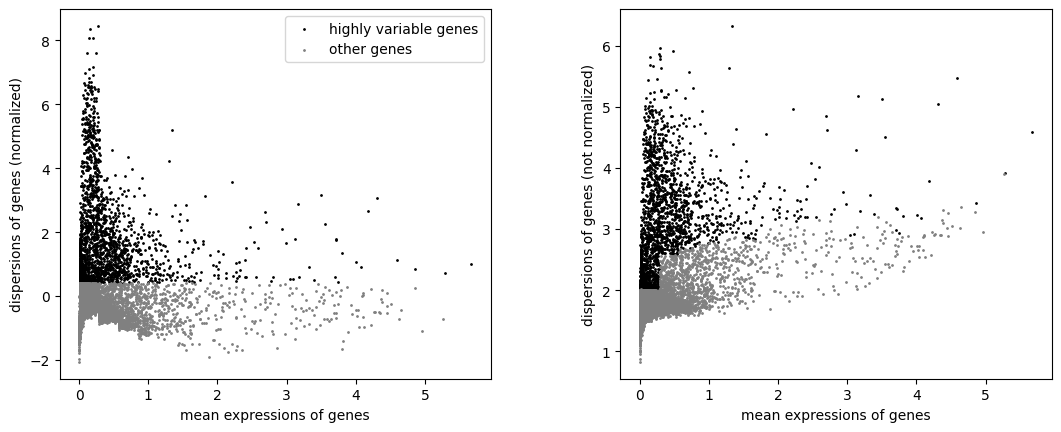

In [44]:
sc.pl.highly_variable_genes(adata)

In [45]:
adata.raw = adata

In [46]:
adata = adata[:, adata.var.highly_variable]

In [47]:
adata

View of AnnData object with n_obs × n_vars = 2233 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rib', 'pct_counts_rib'
    var: 'gene_ids', 'mt', 'rib', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [48]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


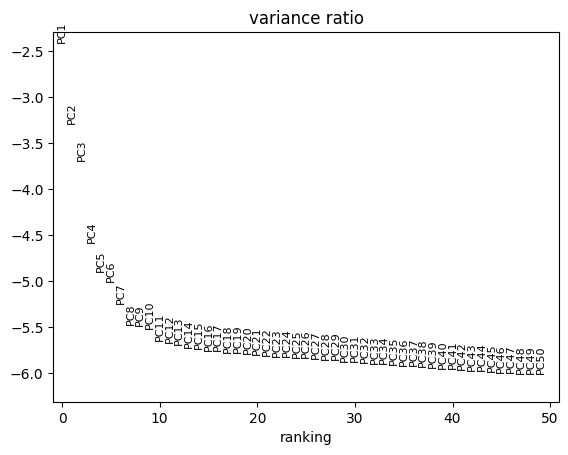

In [133]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [134]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [135]:
sc.tl.umap(adata)

In [138]:
sc.tl.leiden(adata, resolution = 0.5)

In [139]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_rib,pct_counts_rib,leiden
AAACATACAACCAC-1,False,781,2421.0,73.0,3.015283,1046.0,43.205288,0
AAACCGTGCTTCCG-1,False,960,2639.0,46.0,1.743085,644.0,24.403183,1
AAACCGTGTATGCG-1,False,522,981.0,12.0,1.223242,147.0,14.984709,4
AAACGCTGACCAGT-1,False,783,2176.0,83.0,3.814338,896.0,41.176472,3
AAACGCTGGTTCTT-1,False,790,2260.0,70.0,3.097345,866.0,38.318584,3
...,...,...,...,...,...,...,...,...
TTTCGAACACCTGA-1,False,1544,4460.0,58.0,1.300448,1223.0,27.421526,2
TTTCTACTGAGGCA-1,False,1227,3447.0,32.0,0.928343,1143.0,33.159267,2
TTTCTACTTCCTCG-1,False,622,1684.0,37.0,2.197150,670.0,39.786224,2
TTTGCATGAGAGGC-1,False,454,1024.0,21.0,2.050781,284.0,27.734375,2


/Users/ChienTing/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


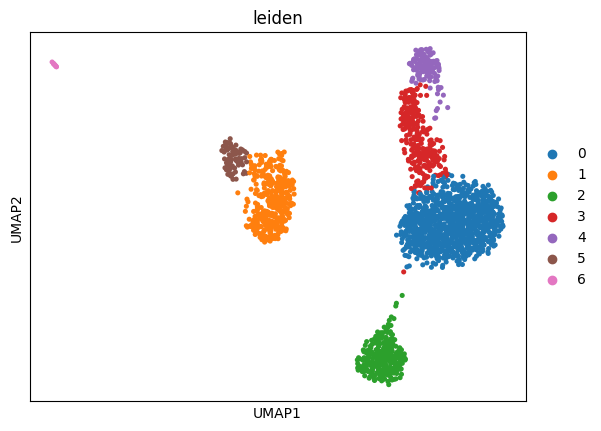

In [140]:
sc.pl.umap(adata, color=['leiden'])

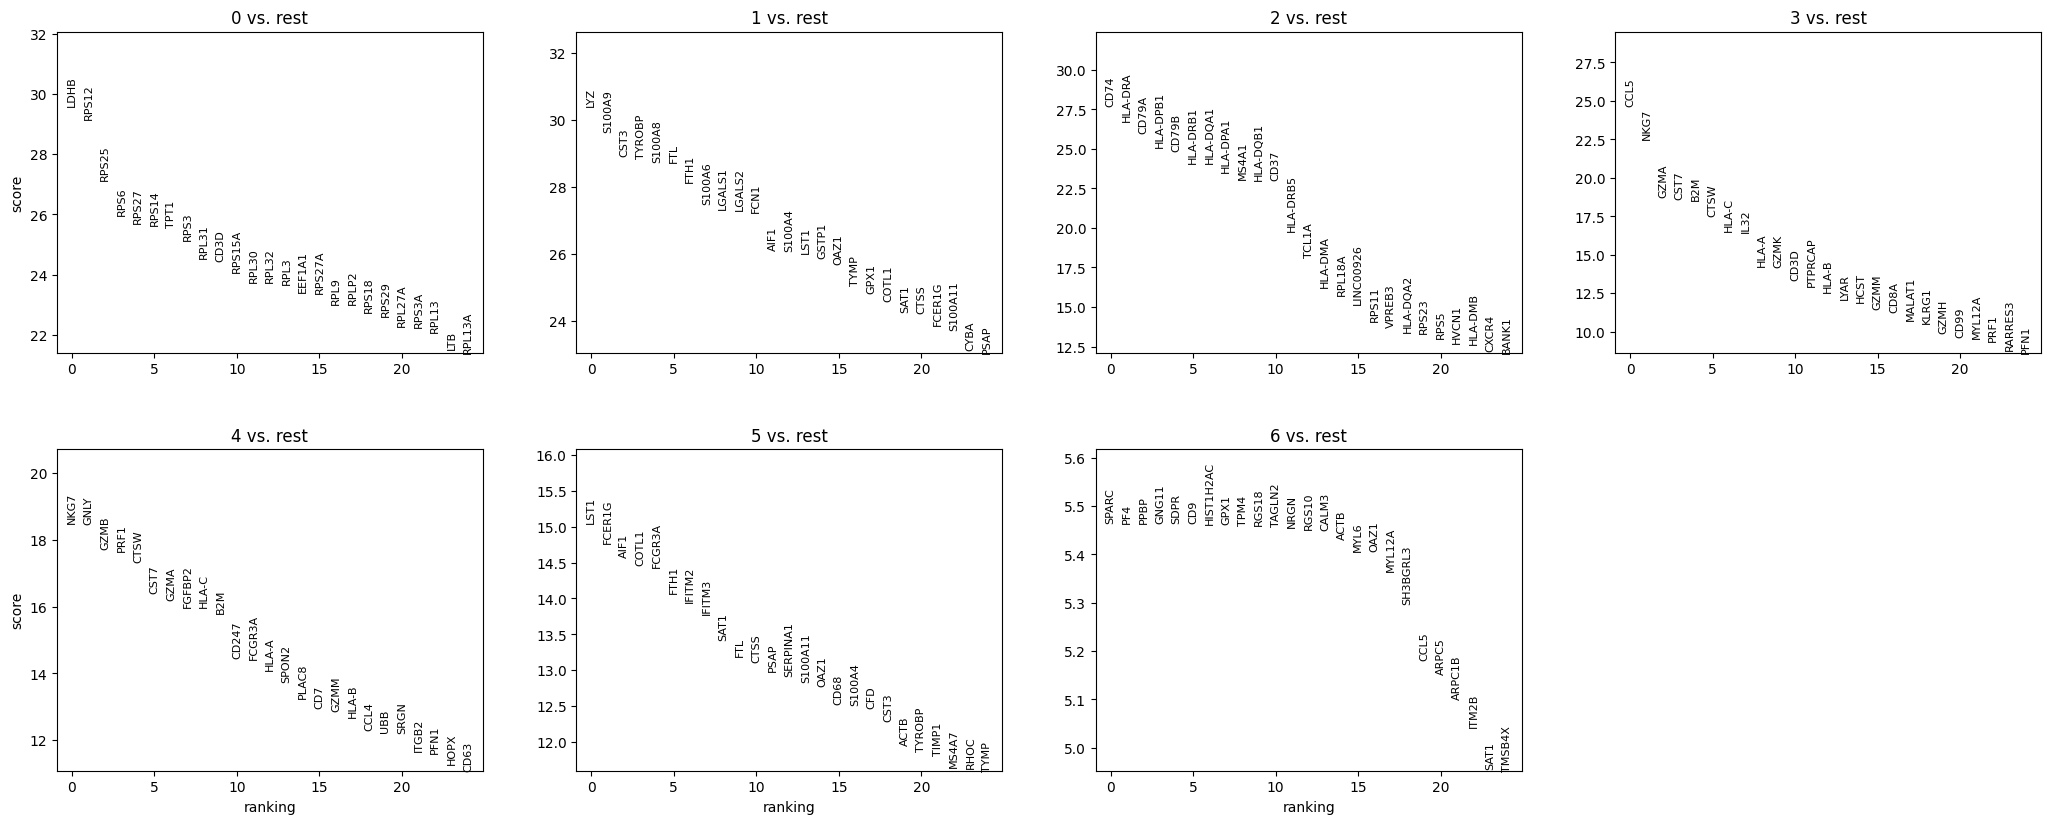

In [158]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [159]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6
0,LDHB,LYZ,CD74,CCL5,NKG7,LST1,SPARC
1,RPS12,S100A9,HLA-DRA,NKG7,GNLY,FCER1G,PF4
2,RPS25,CST3,CD79A,GZMA,GZMB,AIF1,PPBP
3,RPS6,TYROBP,HLA-DPB1,CST7,PRF1,COTL1,GNG11
4,RPS27,S100A8,CD79B,B2M,CTSW,FCGR3A,SDPR


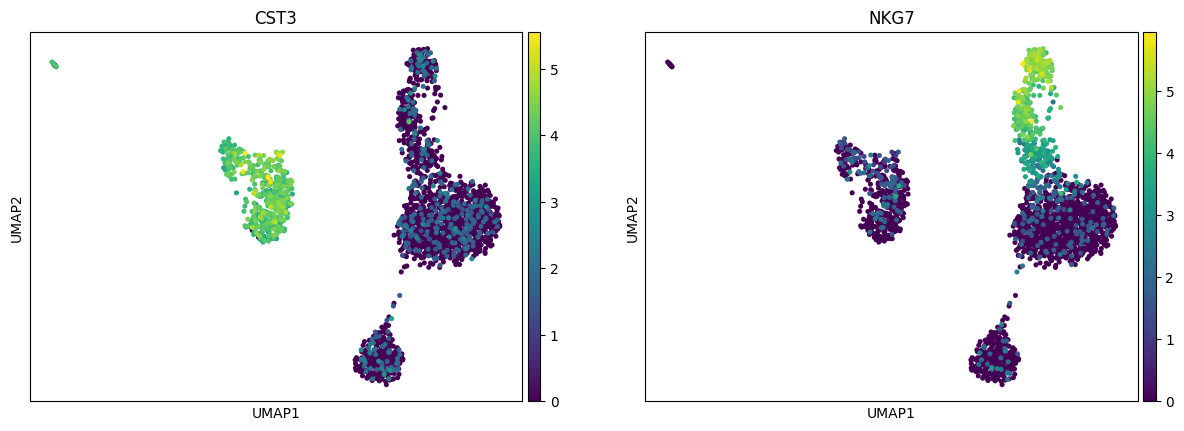

In [162]:
sc.pl.umap(adata, color=['CST3', 'NKG7'])

In [163]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

/Users/ChienTing/anaconda3/lib/python3.10/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


/Users/ChienTing/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


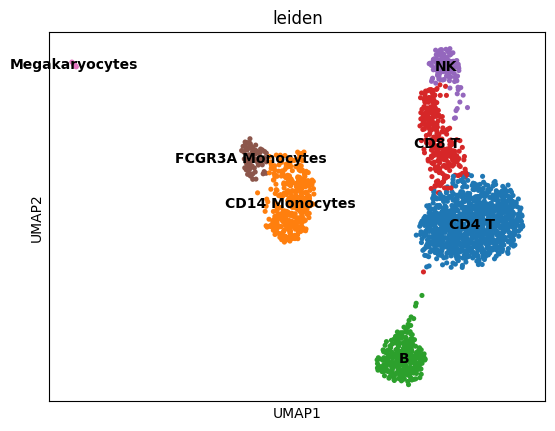

In [164]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')

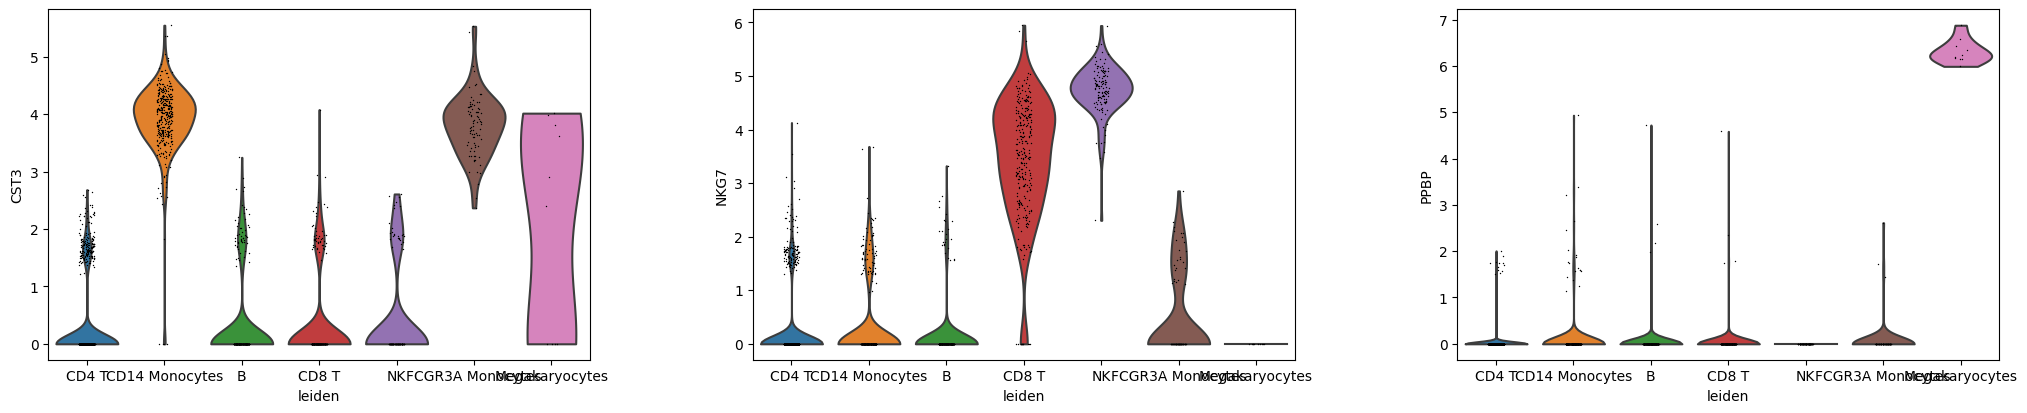

In [165]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [188]:
marker_genes = ['CD3E','CD4','CD14','CD8A','CD8B','CD19','CD22','NKG7']

/Users/ChienTing/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


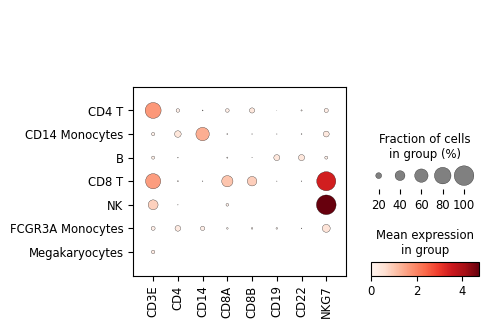

In [189]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');